In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class LSTMCell:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Initialize weights with small values to avoid overflow/underflow
        self.W_f = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_f = np.zeros((hidden_size, 1))
        self.W_i = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_i = np.zeros((hidden_size, 1))
        self.W_C = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_C = np.zeros((hidden_size, 1))
        self.W_o = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_o = np.zeros((hidden_size, 1))
        self.W_y = np.random.randn(output_size, hidden_size) * 0.01
        self.b_y = np.zeros((output_size, 1))
        self.h = np.zeros((hidden_size, 1))
        self.C = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        # Clip input to avoid overflow in exp
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        combined = np.concatenate((self.h, x), axis=0)
        f_t = self.sigmoid(np.dot(self.W_f, combined) + self.b_f)
        i_t = self.sigmoid(np.dot(self.W_i, combined) + self.b_i)
        C_tilde = np.tanh(np.dot(self.W_C, combined) + self.b_C)
        self.C = f_t * self.C + i_t * C_tilde
        o_t = self.sigmoid(np.dot(self.W_o, combined) + self.b_o)
        self.h = o_t * np.tanh(self.C)
        return self.h

    def predict_output(self):
        y = np.dot(self.W_y, self.h) + self.b_y
        return y

    def train(self, input_sequences, target_sequence, epochs=100):
        m = target_sequence.shape[1]  # Number of time steps

        for epoch in range(epochs):
            total_loss = 0

            # Initialize gradients
            dW_f = np.zeros_like(self.W_f)
            dW_i = np.zeros_like(self.W_i)
            dW_C = np.zeros_like(self.W_C)
            dW_o = np.zeros_like(self.W_o)
            dW_y = np.zeros_like(self.W_y)
            db_f = np.zeros_like(self.b_f)
            db_i = np.zeros_like(self.b_i)
            db_C = np.zeros_like(self.b_C)
            db_o = np.zeros_like(self.b_o)
            db_y = np.zeros_like(self.b_y)

            for t in range(m):
                x_t = input_sequences[:, t].reshape(-1, 1)
                h_t = self.forward(x_t)
                y_pred = self.predict_output()
                loss = 0.5 * (y_pred - target_sequence[:, t])**2
                total_loss += loss

                # Backward pass: compute gradients
                dy = y_pred - target_sequence[:, t]
                dW_y += np.dot(dy, self.h.T)
                db_y += dy

                dh = np.dot(self.W_y.T, dy)
                do = dh * np.tanh(self.C)
                dC = dh * self.h * (1 - np.tanh(self.C)**2)
                di = dC * self.C
                df = dC * self.C
                dC_tilde = dC * self.h

                combined_input = np.concatenate((self.h, x_t), axis=0)
                dcombined = np.dot(self.W_f.T, df) + np.dot(self.W_i.T, di) + np.dot(self.W_C.T, dC_tilde) + np.dot(self.W_o.T, do)
                dW_f += np.dot(df * (self.h - self.C), combined_input.T)
                db_f += df
                dW_i += np.dot(di * (self.h - self.C), combined_input.T)
                db_i += di
                dW_C += np.dot(dC_tilde * (self.h - self.C), combined_input.T)
                db_C += dC_tilde
                dW_o += np.dot(do * (self.h - self.C), combined_input.T)
                db_o += do

            # Update weights after each epoch
            self.W_f -= self.learning_rate * dW_f
            self.b_f -= self.learning_rate * db_f
            self.W_i -= self.learning_rate * dW_i
            self.b_i -= self.learning_rate * db_i
            self.W_C -= self.learning_rate * dW_C
            self.b_C -= self.learning_rate * db_C
            self.W_o -= self.learning_rate * dW_o
            self.b_o -= self.learning_rate * db_o
            self.W_y -= self.learning_rate * dW_y
            self.b_y -= self.learning_rate * db_y

            # Print loss to track progress
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss[0, 0] / m}")

    def predict(self, input_sequences):
        m = input_sequences.shape[1]  # Number of time steps
        predictions = []

        for t in range(m):
            x_t = input_sequences[:, t].reshape(-1, 1)
            h_t = self.forward(x_t)
            y_pred = self.predict_output()
            predictions.append(y_pred.flatten())

        return np.array(predictions)

# Load the data for prediction
df2 = pd.read_csv("result_dataset.csv")
df2 = df2[:200]
input_df2 = df2[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
target_df2 = pd.read_csv("total_closeing_prince.csv")
target_df2 = target_df2[:200]

# Scaling the input and target data
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

input_sequences2_scaled = scaler_x.fit_transform(input_df2).T
target_sequence2_scaled = scaler_y.fit_transform(target_df2).T

# Initialize and train the LSTM model
model = LSTMCell(input_size=input_sequences2_scaled.shape[0], hidden_size=50)  # Increased hidden size

# Train the model on the input and target sequences
model.train(input_sequences2_scaled, target_sequence2_scaled, epochs=3000) #increased epoch size

# Predicting
predicted_close_scaled = model.predict(input_sequences2_scaled)

# Reshape the predictions and inverse-transform to the original scale
predicted_close_scaled = predicted_close_scaled.T
predicted_close = scaler_y.inverse_transform(predicted_close_scaled)
predicted_close = predicted_close.flatten().reshape(-1, 1)

# Convert predictions to DataFrame
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])
print(predicted_close_df)

# Accuracy function implementation
def accuracy_function(actual, predicted, tolerance=0.05):
    """
    Calculate the percentage of predictions that are within a specified tolerance range of the actual values.
    
    :param actual: The actual values (numpy array)
    :param predicted: The predicted values (numpy array)
    :param tolerance: The tolerance within which a prediction is considered accurate (default is 5%)
    :return: Accuracy as a percentage of accurate predictions
    """
    percentage_error = np.abs((predicted - actual) / actual)
    accurate_predictions = np.sum(percentage_error <= tolerance)
    accuracy = (accurate_predictions / len(actual)) * 100
    return accuracy

# Calculate custom accuracy
actual_close = target_df2.to_numpy()
accuracy = accuracy_function(actual_close, predicted_close, tolerance=0.05)

print(f"Accuracy: {accuracy}%")
# Calculate accuracy using regression metrics
actual_close = target_df2.to_numpy()

# Mean Squared Error
mse = mean_squared_error(actual_close, predicted_close)
# Mean Absolute Error
mae = mean_absolute_error(actual_close, predicted_close)
# R-squared
r2 = r2_score(actual_close, predicted_close)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Epoch 1/3000, Loss: 0.10347696170308565
Epoch 2/3000, Loss: 0.07440888020704066
Epoch 3/3000, Loss: 0.05581626305089985
Epoch 4/3000, Loss: 0.043922969203273994
Epoch 5/3000, Loss: 0.036314782255267165
Epoch 6/3000, Loss: 0.031447490226098426
Epoch 7/3000, Loss: 0.028333364501094825
Epoch 8/3000, Loss: 0.026340621477497647
Epoch 9/3000, Loss: 0.025065151654807015
Epoch 10/3000, Loss: 0.024248473353342487
Epoch 11/3000, Loss: 0.023725253221620394
Epoch 12/3000, Loss: 0.023389738631902048
Epoch 13/3000, Loss: 0.023174286739805552
Epoch 14/3000, Loss: 0.023035630967002594
Epoch 15/3000, Loss: 0.022946096593443596
Epoch 16/3000, Loss: 0.02288798196229417
Epoch 17/3000, Loss: 0.02284996451452646
Epoch 18/3000, Loss: 0.02282480197091628
Epoch 19/3000, Loss: 0.022807861932759247
Epoch 20/3000, Loss: 0.022796181366339527
Epoch 21/3000, Loss: 0.022787865018403564
Epoch 22/3000, Loss: 0.022781700623004913
Epoch 23/3000, Loss: 0.022776912775209334
Epoch 24/3000, Loss: 0.022773005500663256
Epoch 2

In [15]:
print(predicted_close_df)

     Predicted_Close
0           0.304885
1           0.312269
2           0.316144
3           0.318732
4           0.319767
..               ...
195         0.290276
196         0.289948
197         0.290010
198         0.289912
199         0.289523

[200 rows x 1 columns]


In [3]:
print("Unique values in predictions:", np.unique(predicted_close))

Unique values in predictions: [179.28702397 179.34148457 179.39831583 179.48061264 179.61905821
 179.6976596  179.75942647 179.77086817 179.7727372  179.78074411
 179.78164371 179.8174879  179.82755603 179.86312334 179.87011624
 179.89392856 179.91775971 179.95004513 180.02381554 180.05341802
 180.05792411 180.06249509 180.09481998 180.09984992 180.10118262
 180.12824149 180.1537511  180.17448471 180.17551956 180.18954224
 180.19081882 180.24444308 180.2540732  180.25775206 180.25887324
 180.2669142  180.28557244 180.29297248 180.30711299 180.33262132
 180.34070386 180.34199337 180.34729206 180.35093542 180.39246409
 180.42494729 180.4471475  180.45794493 180.45951254 180.52846589
 180.54070794 180.55130562 180.58221054 180.59611137 180.63873134
 180.68149688 180.68183952 180.68856637 180.7204717  180.82465868
 180.83234516 180.83243614 180.87450144 180.88917659 180.90829334
 180.95072959 180.95744015 180.9590472  180.96339391 181.02290614
 181.07143814 181.08018846 181.12715789 181.17

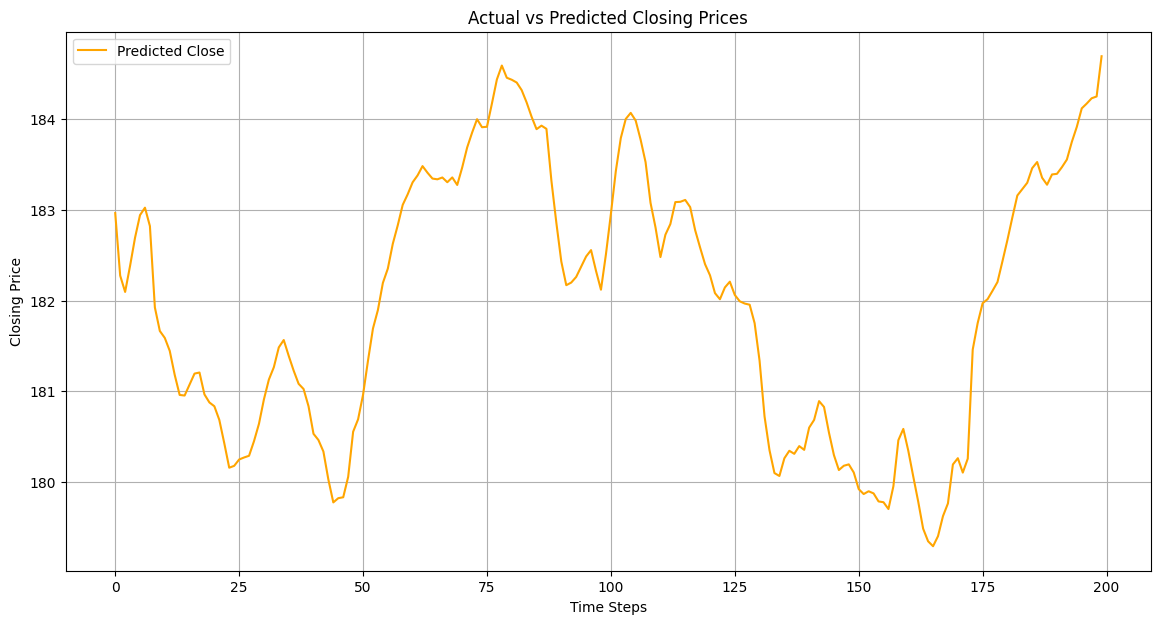

In [4]:
import matplotlib.pyplot as plt

# Assuming actual_close is scaled back to original values and is already computed
actual_close = scaler_y.inverse_transform(target_sequence2_scaled.T)  # Reshape to match dimensions

# Convert to DataFrame for easier plotting
actual_close_df = pd.DataFrame(actual_close, columns=["Actual_Close"])
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])

# Create a time index for the x-axis (assuming it's just a range of integers for now)
time_index = np.arange(len(actual_close))

# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


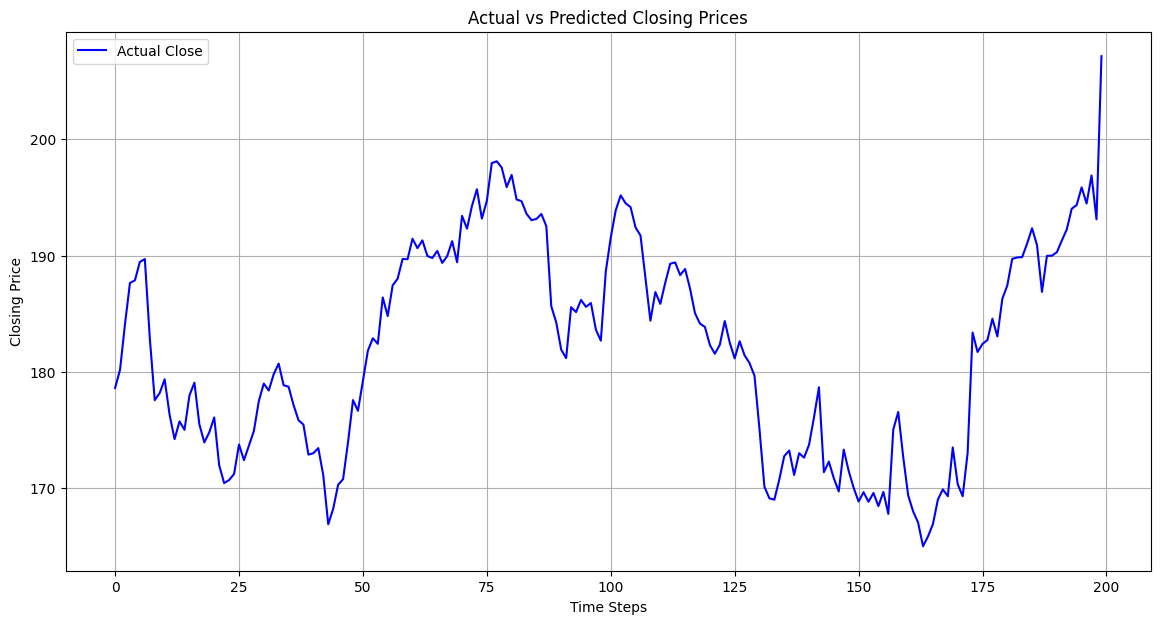

In [5]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
#plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

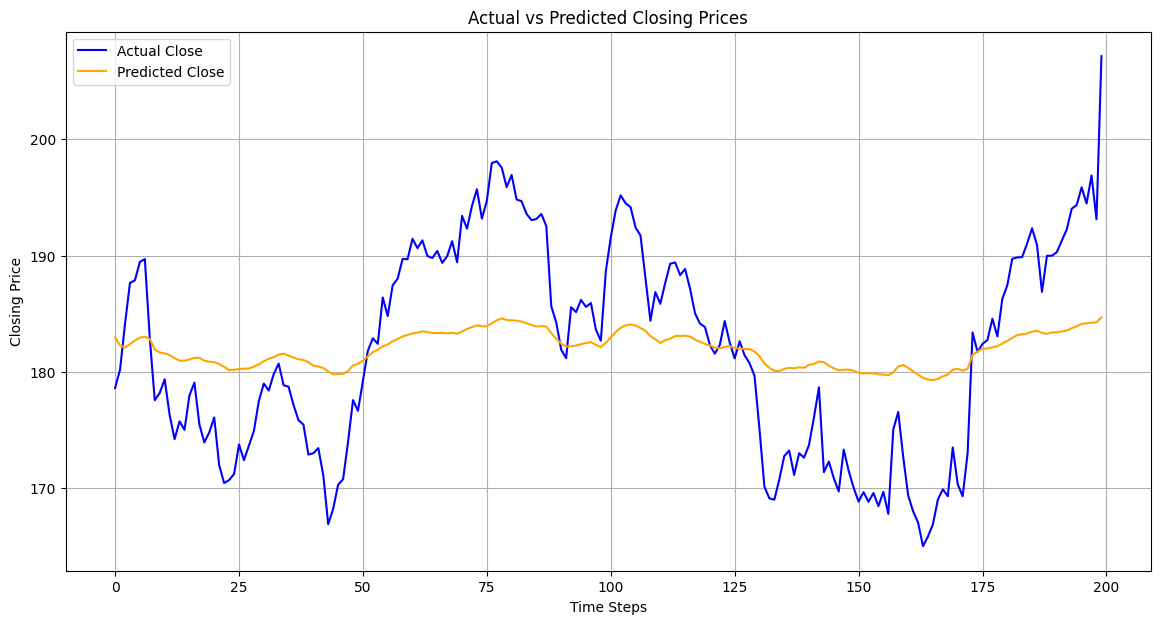

In [6]:
actual_close_df = pd.DataFrame(actual_close, columns=["Actual_Close"])
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])

# Create a time index for the x-axis (assuming it's just a range of integers for now)
time_index = np.arange(len(actual_close))

# Plotting - No need to scale actual_close (already scaled during training)
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

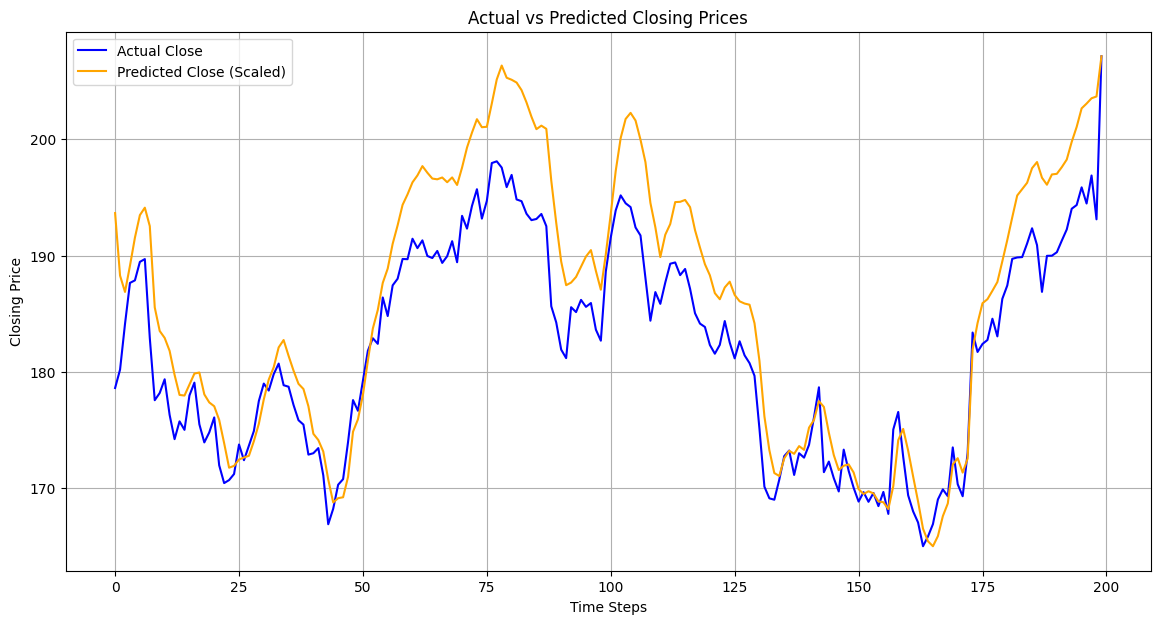

In [7]:
# Create a new scaler for predicted values (optional)
predicted_scaler = MinMaxScaler(feature_range=(min(actual_close), max(actual_close)))

# Scale the predicted values (optional)
predicted_close_scaled = predicted_scaler.fit_transform(predicted_close.reshape(-1, 1))

# Convert scaled predicted values to DataFrame (optional)
predicted_close_df_scaled = pd.DataFrame(predicted_close_scaled.flatten(), columns=["Predicted_Close (Scaled)"])

# Plotting - Scale predicted values if desired
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
# Plot scaled predicted values or original predicted values depending on your preference
# plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.plot(time_index, predicted_close_df_scaled["Predicted_Close (Scaled)"], label='Predicted Close (Scaled)', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()